<div style="width:100%; height:140px">
    <img src="https://www.kuleuven.be/internationaal/thinktank/fotos-en-logos/ku-leuven-logo.png/image_preview" width = 300px, heigh = auto align=left>
</div>


KUL H02A5a Computer Vision: Group Assignment 2
---------------------------------------------------------------
Student numbers: <span style="color:red">r0708518, r0927391, r0925509, r0924356, r0912639</span>.

# 1. Introduction and overview
This assignment consists of *three main parts*:
* Image classification (Section 2)
* Semantic segmentation (Section 3)
* Adversarial attacks (Section 4)

In the first part, we train an end-to-end neural network for image classification. In the second part, we do the same for semantic segmentation. In the third part, we try to find and exploit the weaknesses of our classification and/or segmentation network. Finally, we reflect and produce an overall discussion with links to the lectures and "real world" computer vision (Section 5).

## 1.1 Deep learning
We start by loading the required packages for our notebook. We rely on [Tensorflow](https://www.tensorflow.org/) to build our deep learning architectures. A crash course on Tensorflow can be found [here](https://colab.research.google.com/drive/1UCJt8EYjlzCs1H1d1X0iDGYJsHKwu-NO).

In [ ]:
# Default packages
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import cv2
from PIL import Image
from tqdm.notebook import tqdm
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [12]:
# Deep learning specific packages
import tensorflow as tf
from keras.models import *
from keras.layers import *
from keras.optimizers import *

from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import argmax
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras import backend as keras
import keras.losses
from keras import regularizers #fixing overfitting with L2 regularization
import keras.backend as K
from keras.preprocessing.image import *
from skimage.transform import resize

## 1.2 PASCAL VOC 2009
For this project, we will consider data from the [PASCAL VOC 2009](http://host.robots.ox.ac.uk/pascal/VOC/voc2009/index.html) dataset. The goal of using this dataset is to recongize objects embedded into realistic scenes, meaning that the images are not preprocessed to pre-segmented objects. Therefore, it is a supervised learning problem where the input data are images and the output data are the labels of the objects that are present in the image. There are twenty different objects present in the dataset:
* Person: person
* Animal: bird, cat, cow, dog, horse, sheep
* Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
* Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

In this first section, we will consider the **classification** part of the competition, where the goal is to predict the presence/absence of a class in the images of the test set. In the second section, we consider the **segmentation** part of the competition, where the goal is instead to generate pixel-wise segmentations that determine the class of the object visible at each pixel (or whether the pixel is belonging to the background). 

Let us start by loading the data provided by the Kaggle competition.

In [2]:
# Loading the training data
train_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/train_set.csv', index_col="Id")
labels = train_df.columns[0:20]
train_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/img/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
train_df["seg"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/train/seg/train_{}.npy'.format(idx)) for idx, _ in train_df.iterrows()]
print("The training set contains {} examples.".format(len(train_df)))

The training set contains 749 examples.


In [3]:
# Loading the test data
test_df = pd.read_csv('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/test_set.csv', index_col="Id")
test_df["img"] = [np.load('/kaggle/input/kul-h02a5a-computer-vision-ga2-2023/test/img/test_{}.npy'.format(idx)) for idx, _ in test_df.iterrows()]
test_df["seg"] = [-1 * np.ones(img.shape[:2], dtype=np.int8) for img in test_df["img"]]
print("The test set contains {} examples.".format(len(test_df)))

The test set contains 750 examples.


Before we jump into the problem it is advised to consider the provided data and their meaning. The first row of the dataset is shown below:

In [4]:
train_df.head(1)

,aeroplane,bicycle,bird,boat,bottle,bus,car,cat,chair,cow,...,horse,motorbike,person,pottedplant,sheep,sofa,train,tvmonitor,img,seg
Id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,"[[[10, 8, 13], [16, 14, 19], [17, 14, 21], [19...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


 The given dataframes contain 22 columns, where the first 20 correspond to the classes that are present in the Pascal VOC dataset. A value of $0$ denotes that the corresponding object is not present in the image, while a value of $1$ indicates that the object is present in the image.

In [5]:
labels.shape
print(np.linspace(0, 20, 21))

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]


As an extra, we use a colormap based on the labels of the Pascal dataset:

In [6]:
# Get discrete colorbar
cmap = plt.cm.viridis
cmaplist = [cmap(i) for i in range(cmap.N)]
# create the new map
pascal_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
pascal_norm = mpl.colors.BoundaryNorm(np.arange(0.5,20+1), cmap.N) 

The remaining two columns provide the image and the segmentations. The segmentations have the same 2D shape as the images, but have only one channel. Here, the "pixels" consist of integers between 0 and 20, and denote whether a pixel is part of an object of the labels. We demonstrate this with an example:

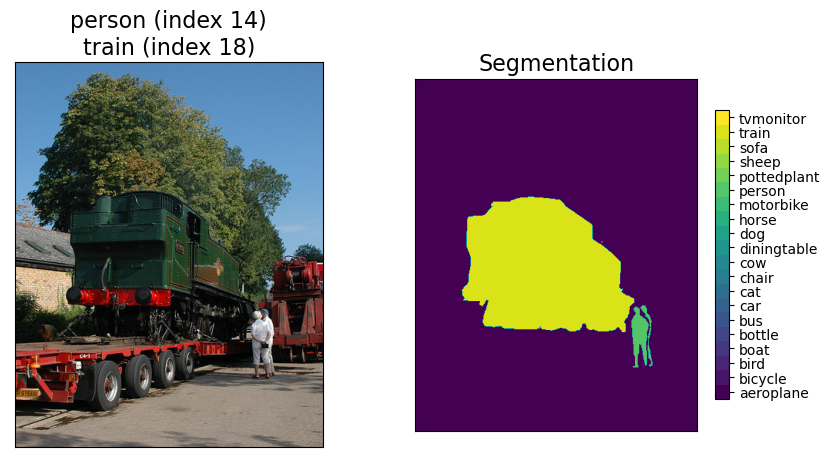

In [7]:
# Get an example image
ind = 7
example_img = train_df.loc[ind]["img"]
example_seg = train_df.loc[ind]["seg"]
# Show the image and the segmentation
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax1, ax2 = axs

# Show the picture
ax1.imshow(example_img)
ax1.set_title("\n".join(f"{label} (index {np.argwhere(labels==label)[0][0]})" for label in labels if train_df.iloc[ind][label] == 1), fontsize=16)

# Show segmentation with colorbar
im = ax2.imshow(example_seg, cmap=pascal_cmap, norm=pascal_norm)
cbar = fig.colorbar(im, ax=ax2, shrink=0.75, ticks=np.linspace(1, 20, 20))
cbar.ax.set_yticklabels(labels)
ax2.set_title("Segmentation", fontsize=16)

# Remove ticks
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## 1.3 Utilities
Below, we define a few auxiliary functions. First, we define functions to simplify generating the Kaggle submission:

In [8]:
def _rle_encode(img):
    """
    Kaggle requires RLE encoded predictions for computation of the Dice score (https://www.kaggle.com/lifa08/run-length-encode-and-decode)

    Parameters
    ----------
    img: np.ndarray - binary img array
    
    Returns
    -------
    rle: String - running length encoded version of img
    """
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    rle = ' '.join(str(x) for x in runs)
    return rle

def generate_submission(df):
    """
    Make sure to call this function once after you completed Sect. 2 and Sect. 3! It transforms and writes your test dataframe into a submission.csv file.
    
    Parameters
    ----------
    df: pd.DataFrame - filled dataframe that needs to be converted
    
    Returns
    -------
    submission_df: pd.DataFrame - df in submission format.
    """
    df_dict = {"Id": [], "Predicted": []}
    for idx, _ in df.iterrows():
        df_dict["Id"].append(f"{idx}_classification")
        df_dict["Predicted"].append(_rle_encode(np.array(df.loc[idx, labels])))
        df_dict["Id"].append(f"{idx}_segmentation")
        df_dict["Predicted"].append(_rle_encode(np.array([df.loc[idx, "seg"] == j + 1 for j in range(len(labels))])))
    
    submission_df = pd.DataFrame(data=df_dict, dtype=str).set_index("Id")
    submission_df.to_csv("submission.csv")
    return submission_df

We also define an auxiliary function to reshape images using OpenCV:

In [9]:
def reshape_images(images, size):
    """
    Simple auxiliary function to reshape a given sequence of images to the square shape (size, size).
    Parameters
    ----------
    images: list, np.array - Array of images to be resized.
    size: int - Size along one dimension of the final images. Shape will be (size, size).
    
    Returns
    -------
    new_images_array: np.array -  Resized images inside a numpy array
    
    """
    new_images = []
    # Resize each image in the given sequence
    for img in images:
        resized = cv2.resize(img, (size, size), interpolation=cv2.INTER_AREA)
        new_images.append(resized)
    # Convert from list to array
    new_images_array = np.array(new_images)
    return new_images_array

In [10]:
def show_training(history):
    """
    Plots the training of a Keras model, based on the history provided by the fit methods.
    """
    train_loss  = history["loss"]
    val_loss    = history["val_loss"]
    train_acc   = history["binary_accuracy"]
    val_acc     = history["val_binary_accuracy"]
    epochs_list = np.linspace(1, len(train_loss), len(train_loss))

    # Make a plot
    plt.subplots(nrows=1, ncols=1, figsize=(12, 3))

    plt.subplot(121)
    plt.plot(epochs_list, train_loss, '-o', color="red", label="Train")
    plt.plot(epochs_list, val_loss, '-o', color="blue", label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid()
    plt.yscale('log')
    plt.legend()

    plt.subplot(122)
    plt.plot(epochs_list, train_acc, '-o', color="red", label="Train")
    plt.plot(epochs_list, val_acc, '-o', color="blue", label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.grid()

    plt.show()

# 2. Image classification

As already mentioned, this first section will deal with the classification task of the Pascal VOC dataset. The goal is to implement a deep learning architecture, namely a **convolutional neural network** (CNN), and train it to recognise all the 20 classes of the dataset, as shown for instance in the example image above. The CNN should process the image on the left and correctly predict the presence of the train and person class for that image. Before we delve into the code, we provide an overview and explanation of the different set-ups we have considered for this work, to keep the discussion compact and organized.

This section is divided into four **TODO: five if hand-made is added!** parts, related to the different architectures that we have investigated and compared for the classification part. These are, in chronological order,
1. MobileNetV2 (Section 2.1)
2. VGG16 (Section 2.2)
3. InceptionV3 (Section 2.3)
4. MobileNet (Section 2.4)

Each section is subdivided into three subsections, which are related to the different training mechanisms that we considered:

1. Transfer learning (Section 2.X.1)
2. Transfer learning with fine-tuning (Section 2.X.2)
3. Training the weights from scratch (Section 2.X.3)

We will briefly discuss the key properties of the different architectures. The specific architecture designs are shown at the beginning of each subsection. The details of the training, hyperparameter selection and a comparison between the training methods are discussed in Section 2.1 for the MobileNetV2 architecture. The other sections make use of very similar set-ups and hyperparameter settings, so we only provide the necessary code there and readers are encouraged to read through Section 2.1 for explanation. 

The first architecture we consider is **MobileNetV2**, developed at Google [1]. The architecture is simple and makes use of bottleneck residual blocks besides the conventional convolutional and pooling layers. These consist of a sequence of three layers. The first is a $1 \times 1$ 2D convolutional layer with a ReLU6 activation function ($\text{ReLU6}(x) = \min\left( \max\left( 0, x \right), 6 \right)$). The second is a $3 \times 3$ depthwise convolutional layer, again with ReLU6 activation function. A *depthwise separable convolution* factorizes the standard convolutional operator into two layers. The first layer is a depthwise convolution which uses a single convolutional filter per input channel. The second layer performs a pointwise convolution, with kernel size $1 \times 1$, to build new features. The advantage of these operators is that their computational cost is 8 to 9 times smaller than standard convolutions, at only a small reduction in the accuracy. The final part of the bottleneck residual block uses a linear $1\times 1$ convolutional layer. Overall, MobileNetV2 has less parameters than MobileNetV1 (discussed below).

The second architecture we investigate is **VGG16** [2]. The novel insight that this paper put forward was that significant improvements in the accuracy can be achieved by increasing their depth by adding more convolutional layers, which is made feasible by using very small $3 \times 3$ convolutional filters in all layers, which is the smallest receptive field that can capture the notions of left/right and down/up. The network uses standard ReLU activation functions. The drawback of the architecture is that it is over 533MB, which makes deploying VGG a tiresome task [3]. Smaller network architectures can therefore be desirable. VGG16 outperformed state-of-the-art models at its time of introduction in the ILSVRC-2012 and ILSVRC-2013 competitions. 

The third architecture we use is **InceptionV3**. 


**References:**

[1] Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). *Mobilenetv2: Inverted residuals and linear bottlenecks*. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4510-4520).

[2] Simonyan, K., & Zisserman, A. (2014). *Very deep convolutional networks for large-scale image recognition*. arXiv preprint arXiv:1409.1556.

[3] Neurohive. (2018, November 20). *VGG16 - Convolutional Network for Classification and Detection*. Retrieved May 16, 2023, from https://neurohive.io/en/popular-networks/vgg16/

First, we reshape the images into the desired shape. We then have 749 train images of size $(224, 224)$ as this is the input dimension that all our architectures use. Each training image has a corresponding label which is a one-hot encoded vector of size 20.

In [13]:
X_train = reshape_images(train_df["img"], 224)
y_train = np.asarray(train_df[train_df.columns[:20]])
X_test = reshape_images(test_df["img"], 224)
print(f"Shape of X_train is {X_train.shape}")
print(f"Shape of y_train is {y_train.shape}")
print(f"Shape of X_test  is {X_test.shape}")

Shape of X_train is (749, 224, 224, 3)
Shape of y_train is (749, 20)
Shape of X_test  is (750, 224, 224, 3)


## 2.1 MobileNetV2

The architecture is shown below. First, a regular convolution is applied. Then, several linear bottleneck layers, discussed in detail in the paper, are applied. Finally, after the image has been downsampled to a $7\times 7$ image with 1280 kernels, an averaging pool is used to get a vector of $1280$ features which can then be processed into a classifier. Below, we flatten the output layer (to go from shape $1\times 1 \times 1280$ to shape $1280$) and process these features into a classifier. 

<figure style="text-align: center;">
    <img src=https://miro.medium.com/v2/resize:fit:1016/1*5iA55983nBMlQn9f6ICxKg.png>
    <figcaption>The MobileNetV2 architecture.</figcaption>
</figure>

### 2.1.1 Transfer learning

First, we consider the case of **transfer learning**. The `MobileNetV2_Model` class implements a pre-trained MobileNetV2 model for image classification. It allows us to leverage the MobileNetV2 architecture and customize it for our specific classification task on images from the Pascal VOC dataset.

The class initializes the MobileNetV2 model with pre-trained weights from the ImageNet dataset. It then modifies the model by replacing the fully connected layers with a new flattened layer of the final output of the MobileNetV2 architecture and a dense (*i.e.*, fully connected) layer with a sigmoid activation function. This final layer has 20 output nodes, such that it is compatible with the Pascal VOC dataset which has 20 classes.

The `fit()` method enables training of the modified model on our dataset. It preprocesses the input images using the MobileNetV2 preprocessing function, compiles the model with a chosen optimizer and loss function. Here, we have chosen for the **Adam optimizer** and a **cross-entropy loss**. In Adam, derived from “adaptive moments” one computes an unbiased estimate for the first and second moments of the gradient. Adam is generally regarded as fairly robust to the choice of hyperparameters. Details can be found in Section 8.5.3 of the book [*Deep Learning*](https://www.deeplearningbook.org/) by Goodfellow *et al.*. The cross-entropy loss **TODO discuss**

The model is trained for 20 epochs on our own dataset. We use a learning rate of $10^{-5}$ as this empirically gave good results. We make us of early stopping to prevent overfitting, with patience of $3$ epochs and threshold improvement of $0.01$. For this, we use a train-validation split, and use $20\%$ of the dataset as validation data. We also process the training data in batches of size $32$.

To make new predictions, the `predict()` method preprocesses new input images and returns the predicted class probabilities for each image using the trained model. The `__call__()` method allows the class instance to be invoked as a function, providing a convenient way to make predictions on new data.

In [ ]:
# Specify where the trained model should be saved:
# SAVE_LOCATION = "/kaggle/working/mobv2_m1_best.h5"

class MobileNetV2_Model:
    """
    A class representing a MobileNetV2 model for image classification.

    Attributes
    ----------
    model : tf.keras.Model
        The MobileNetV2 model.

    Methods
    -------
    __init__()
        Initializes the MobileNetV2 model.
    fit(X, y)
        Trains the MobileNetV2 model with training images X and labels y.
    predict(X)
        Performs predictions using the MobileNetV2 model.
    __call__(X)
        Calls the predict() method.

    """

    def __init__(self):
        """
        Initializes the MobileNetV2 model.

        This function constructs a MobileNetV2 model with pre-trained weights from ImageNet.
        The fully connected layers of the original model are replaced with a new flattened layer
        and a dense layer with 20 units and sigmoid activation.

        """
        # Load in the MobileNetV2 architecture from Keras, use weights from Imagenet
        mobv2_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze all layers of the MobileNetV2 model
        for l in mobv2_model.layers:
            l.trainable = False

        # Add new layer on top of the MobileNetV2 model to process our dataset
        new_l = tf.keras.layers.Flatten()(mobv2_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create a new model with the modified layers
        self.model = tf.keras.Model(inputs=mobv2_model.input, outputs=new_l)

    def fit(self, X, y):
        """
        Trains the MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).
        y : np.array
            The target labels as a numpy array with shape (num_samples, num_classes).

        """
        X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X)

        # Compile the model with settings for optimization and loss calculation
        self.model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        # Set up callbacks for early stopping and saving the best model
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.001),
            tf.keras.callbacks.ModelCheckpoint(
                filepath=SAVE_LOCATION,
                monitor="val_loss",
                save_best_only=True
            )
        ]

        # Train the model
        history = self.model.fit(
            X_train, y,
            epochs=30,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )
        
        # Store the information obtained during training as field
        self.history = history

    def predict(self, X):
        """
        Performs predictions using the MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        """
        Calls the predict() method.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)


Now, define a new instance of the model, and train it on the Pascal VOC dataset:

In [ ]:
# Define an instance:
mobv2_m1 = MobileNetV2_Model()
## Show complete architecture -- lengthy output!
# mobv2_m1.model.summary()
# Train on Pascal VOC dataset
mobv2_m1.fit(X_train, y_train)

We can visualize the training by plotting:

In [ ]:
show_training(mobv2_m1.history.history)

### 2.1.2 Transfer learning and finetuning

We explored an alternative to the previous training set-up, where we allow to finetune the architecture on top of the transfer learning, which we implement in the `MobileNetV2_fine_Model` class. This class also uses transfer learning as before, and hence much of the code will be similar to the previous class. However, now we include an additional step called **fine-tuning**. After the modified model is trained with the initial hyperparameters, the layers of the base MobileNetV2 model are unfrozen, allowing them to be trained along with our custom layers. This fine-tuning step aims to further improve the base model's performance by allowing the lower layers to learn more specific features from our new dataset. This allows us to get more flexibility in the model and can yield a more capable network.

In [ ]:
class MobileNetV2_fine_Model:
    """
    A class representing a fine-tuned MobileNetV2 model for image classification.

    Attributes
    ----------
    model : tf.keras.Model
        The fine-tuned MobileNetV2 model.

    Methods
    -------
    __init__(X, y)
        Initializes and trains the fine-tuned MobileNetV2 model.
    predict(X)
        Performs predictions using the fine-tuned MobileNetV2 model.
    __call__(X)
        Calls the predict() method.

    """

    def __init__(self, X, y):
        """
        Initializes and trains the fine-tuned MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).
        y : np.array
            The target labels as a numpy array with shape (num_samples, num_classes).

        """
        base_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze all layers of the base MobileNetV2 model
        base_model.trainable = False

        # Add new layers on top of the base model
        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the new model with the modified layers
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X)

        # Compile and train the model with the first set of hyperparameters
        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.001),
            tf.keras.callbacks.ModelCheckpoint(
                filepath="../../data_ga2/models/mobv2_m2_best.h5",
                monitor="val_loss",
                save_best_only=True
            )
        ]

        pre_history = model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )

        # Allow ALL layers of the base model to be trainable
        base_model.trainable = True

        # Compile and train the model with the second set of hyperparameters
        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-6),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        history = model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )

        self.model = model
        self.pre_history = pre_history
        self.history = history

    def predict(self, X):
        """
        Performs predictions using the fine-tuned MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        """
        Calls the predict() method.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

In [ ]:
mobv2_m2 = MobileNetV2_fine_Model(X_train, y_train)

In [ ]:
show_training(mobv2_m2.history.history)

### 2.1.3 Training from scratch

In [ ]:
class MobileNetV2_scratch_Model:
    """
    A class representing a MobileNetV2 model trained from scratch for image classification.

    Attributes
    ----------
    model : tf.keras.Model
        The MobileNetV2 model trained from scratch.

    Methods
    -------
    __init__()
        Initializes the MobileNetV2 model trained from scratch.
    fit(X, y)
        Trains the MobileNetV2 model on the given dataset.
    predict(X)
        Performs predictions using the MobileNetV2 model.
    __call__(X)
        Calls the predict() method.

    """

    def __init__(self):
        """
        Initializes the MobileNetV2 model trained from scratch.

        """
        mobv2_model = tf.keras.applications.MobileNetV2(
            include_top=False,
            input_shape=(224, 224, 3),
            weights=None
        )

        # Add new layers on top of the MobileNetV2 model
        new_l = tf.keras.layers.Flatten()(mobv2_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the model with the modified layers
        self.model = tf.keras.Model(inputs=mobv2_model.input, outputs=new_l)

    def fit(self, X, y):
        """
        Trains the MobileNetV2 model on the given dataset.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).
        y : np.array
            The target labels as a numpy array with shape (num_samples, num_classes).

        """
        X_train = tf.keras.applications.mobilenet_v2.preprocess_input(X)

        self.model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath="../../data_ga2/models/mobv2_m3_best.h5",
                monitor="val_loss",
                save_best_only=True
            )
        ]

        history = self.model.fit(
            X_train, y,
            epochs=50,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )
        
        self.history = history

    def predict(self, X):
        """
        Performs predictions using the MobileNetV2 model.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        preprocessed_X = tf.keras.applications.mobilenet_v2.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        """
        Calls the predict() method.

        Parameters
        ----------
        X : np.array
            The input images as a numpy array with shape (num_samples, height, width, channels).

        Returns
        -------
        np.array
            The predicted class probabilities as a numpy array with shape (num_samples, num_classes).

        """
        return self.predict(X)


In [ ]:
mobv2_m3 = MobileNetV2_scratch_Model()
mobv2_m3.fit(X_train, y_train)

In [ ]:
show_training(mobv2_m3.history.history)

## 2.2 VGG16

The architecture is shown below:
<figure style="text-align: center;">
    <img src="https://miro.medium.com/v2/1*NNifzsJ7tD2kAfBXt3AzEg.png" width=75%>
    <figcaption>The VGG16 architecture.</figcaption>
</figure>




### 2.2.1 Transfer learning

In [ ]:
class VGG16_Model:
    def __init__(self):
        vgg_model = tf.keras.applications.VGG16(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze the layers of the VGG16 model
        for l in vgg_model.layers:
            l.trainable = False

        # Add new layers on top of the VGG16 model
        new_l = tf.keras.layers.Flatten()(vgg_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the model with the modified layers
        self.model = tf.keras.Model(inputs=vgg_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.vgg16.preprocess_input(X)

        self.model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-5),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath="../../data_ga2/models/vgg_m1_best.h5",
                monitor="val_loss",
                save_best_only=True
            )
        ]

        history = self.model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )
        
        self.history = history

    def predict(self, X):
        preprocessed_X = tf.keras.applications.vgg16.preprocess_input(X)
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
vgg_m1 = VGG16_Model()
vgg_m1.fit(X_train, y_train)

In [ ]:
show_training(vgg_m1.history.history)

### 2.2.2 Transfer learning with fine-tuning

In [ ]:
class VGG16_fine_Model:
    def __init__(self, X, y):
        base_model = tf.keras.applications.VGG16(
            include_top=False,
            input_shape=(224, 224, 3),
            weights="imagenet"
        )

        # Freeze the layers of the VGG16 base model
        base_model.trainable = False

        # Add new layers on top of the VGG16 base model
        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)

        # Create the model with the modified layers
        model = tf.keras.Model(inputs=base_model.input, outputs=new_l)

        X_train = tf.keras.applications.vgg16.preprocess_input(X)

        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-4),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
            tf.keras.callbacks.ModelCheckpoint(
                filepath="../../data_ga2/models/vgg_m2_best.h5",
                monitor="val_loss",
                save_best_only=True
            )
        ]

        pre_history = model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )

        # Enable training of all layers in the VGG16 model
        base_model.trainable = True

        model.compile(
            run_eagerly=True,
            optimizer=tf.keras.optimizers.Adam(1e-6),
            loss='binary_crossentropy',
            metrics=['binary_accuracy']
        )

        history = model.fit(
            X_train, y,
            epochs=20,
            batch_size=32,
            validation_split=0.2,
            callbacks=callbacks
        )

        self.model = model
        self.pre_history = pre_history
        self.history = history

    def predict(self, X):
        return self.model.predict(preprocessed_X, verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
vgg_m2 = VGG16_fine_Model(X_train, y_train)

In [ ]:
show_training(vgg_m2.history.history)

### 2.2.3 Training from scratch

In [ ]:
class VGG16_scratch_Model:
    def __init__(self):
        vgg_model = tf.keras.applications.MobileNetV2(include_top=False, input_shape=(224,224,3), weights=None)
        new_l = tf.keras.layers.Flatten()(vgg_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=vgg_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.vgg16.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath="../../data_ga2/models/vgg_m3_best.h5", monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.vgg16.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)


In [ ]:
vgg_m3 = VGG16_scratch_Model()
vgg_m3.fit(X_train, y_train)

In [ ]:
show_training(vgg_m3.history.history)

# 2.3 InceptionV3

### 2.3.1 Transfer learning

In [ ]:
class InceptionV3_Model:
    def __init__(self):
        incv3_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3), weights="imagenet")
        for l in incv3_model.layers:
            l.trainable = False
        new_l = tf.keras.layers.Flatten()(incv3_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=incv3_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.inception_v3.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath="../../data_ga2/models/incv3_m1_best.h5", monitor="val_binary_accuracy", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.inception_v3.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)


In [ ]:
incv3_m1 = InceptionV3_Model()
incv3_m1.fit(X_train, y_train)

In [ ]:
show_training(incv3_m1.history.history)

### 2.3.2 Transfer learning and fine-tuning

In [ ]:
class InceptionV3_fine_Model:
    def __init__(self, X, y):
        base_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3), weights="imagenet")
        base_model.trainable = False

        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.inception_v3.preprocess_input(X)

        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath="../../data_ga2/models/incv3_m2_best.h5", monitor="val_binary_accuracy", save_best_only=True)]
        pre_history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.pre_history = pre_history

        base_model.trainable = True
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-6), loss='binary_crossentropy', metrics=['binary_accuracy'])
        history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.model = model
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.inception_v3.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)


In [ ]:
incv3_m2 = InceptionV3_fine_Model(X_train, y_train)

In [ ]:
show_training(incv3_m2.history.history)

### 2.3.3 Training from scratch

In [ ]:
class InceptionV3_scratch_Model:

    def __init__(self):
        incv3_model = tf.keras.applications.InceptionV3(include_top=False, input_shape=(224,224,3), weights=None)
        new_l = tf.keras.layers.Flatten()(incv3_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=incv3_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.inception_v3.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath="../../data_ga2/models/incv3_m3_best.h5", monitor="val_binary_accuracy", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30,batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.inception_v3.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
incv3_m3 = InceptionV3_scratch_Model()
incv3_m3.fit(X_train, y_train)

In [ ]:
show_training(incv3_m3.history.history)

## 2.4 MobileNet

### 2.4.1 Transfer learning

In [ ]:
class MobileNet_Model:
    def __init__(self):
        mob_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224,224,3), weights="imagenet")
        for l in mob_model.layers:
            l.trainable = False
        new_l = tf.keras.layers.Flatten()(mob_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=mob_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.mobilenet.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath="../../data_ga2/models/mob_m1_best.h5", monitor="val_loss", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.mobilenet.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)


In [ ]:
mob_m1 = MobileNet_Model()
mob_m1.fit(X_train, y_train)

In [ ]:
show_training(mob_m1.history.history)

### 2.4.2 Transfer learning and fine-tuning

In [ ]:
class MobileNet_fine_Model:

    def __init__(self, X, y):
        base_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224,224,3), weights="imagenet")
        base_model.trainable = False

        new_l = tf.keras.layers.Flatten()(base_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        model = tf.keras.Model(base_model.input, new_l)

        X_train = tf.keras.applications.mobilenet.preprocess_input(X)

        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath="../../data_ga2/models/mob_m2_best.h5", monitor="val_loss", save_best_only=True)]
        pre_history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.pre_history = pre_history

        base_model.trainable = True
        model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-6), loss='binary_crossentropy', metrics=['binary_accuracy'])
        history = model.fit(X_train, y, epochs=30, batch_size=32, validation_split=0.2, callbacks=callbacks)
        self.model = model
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.mobilenet.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
mob_m2 = MobileNet_fine_Model(X_train, y_train)

In [ ]:
show_training(mob_m2.history.history)

### 2.4.3 Training from scratch

In [ ]:
class MobileNet_scratch_Model:

    def __init__(self):
        mob_model = tf.keras.applications.MobileNet(include_top=False, input_shape=(224,224,3), weights=None)
        new_l = tf.keras.layers.Flatten()(mob_model.output)
        new_l = tf.keras.layers.Dense(20, activation="sigmoid")(new_l)
        self.model = tf.keras.Model(inputs=mob_model.input, outputs=new_l)

    def fit(self, X, y):
        X_train = tf.keras.applications.mobilenet.preprocess_input(X)
        self.model.compile(run_eagerly=True, optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['binary_accuracy'])
        callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_binary_accuracy", patience=2, min_delta=0.01),
                     tf.keras.callbacks.ModelCheckpoint(filepath="../../data_ga2/models/mob_m3_best.h5", monitor="val_binary_accuracy", save_best_only=True)]
        history = self.model.fit(X_train, y, epochs=30,batch_size=32, validation_split=0.25, callbacks=callbacks)
        self.history = history

    def predict(self, X):
        return self.model.predict(tf.keras.applications.mobilenet.preprocess_input(X), verbose=0)

    def __call__(self, X):
        return self.predict(X)

In [ ]:
mob_m3 = MobileNet_scratch_Model()
mob_m3.fit(X_train, y_train)

In [ ]:
show_training(mob_m3.history.history)

## 2.5 Choose the best architecture

In [ ]:
classification_models = [mobv2_m1, mobv2_m2, mobv2_m3, vgg_m1, vgg_m2, vgg_m3, incv3_m1, incv3_m2, incv3_m3, mob_m1, mob_m2, mob_m3]
model_names = ["MobileNetV2", "VGG16", "InceptionV3", "MobileNet"]
classification_names = []
for name in model_names:
    classification_names.append(name + " (TL)")
    classification_names.append(name + " (TL + FT)")
    classification_names.append(name + " (scratch)")

classification_names = np.array(classification_names)

In [ ]:
model = mobv2_m1
history = model.history.history
history.keys()

In [ ]:
classification_val_accs = []
for i, model in enumerate(classification_models):
    name = classification_names[i]
    history = model.history.history
    val_acc = np.max(history["val_binary_accuracy"])
    classification_val_accs.append(val_acc)
    
classification_val_accs = np.array(classification_val_accs)

In [ ]:
sort_ind = np.argsort(classification_val_accs)[::-1]

sorted_classification_val_accs = classification_val_accs[sort_ind]
sorted_classification_names = classification_names[sort_ind]

In [ ]:
xticks = [i for i in range(len(classification_names))]

plt.figure(figsize=(11,3))
plt.plot(xticks, sorted_classification_val_accs, '-o', color="blue")
plt.xticks(xticks, labels=sorted_classification_names, rotation=45)
plt.grid()
plt.ylabel("Validation accuracy")
plt.show()

# 3. Semantic segmentation
The goal here is to implement a segmentation CNN that labels every pixel in the image as belonging to one of the 20 classes (and/or background).

## Submit to competition
You don't need to edit this section. Just use it at the right position in the notebook. See the definition of this function in Sect. 1.3 for more details.

In [ ]:
generate_submission(test_df)

# 4. Adversarial attack
For this part, your goal is to fool your classification and/or segmentation CNN, using an *adversarial attack*. More specifically, the goal is build a CNN to perturb test images in a way that (i) they look unperturbed to humans; but (ii) the CNN classifies/segments these images in line with the perturbations.

# 5. Discussion
Finally, take some time to reflect on what you have learned during this assignment. Reflect and produce an overall discussion with links to the lectures and "real world" computer vision.